# Incompressible Navier Stokes Equations

There are a lot of bugs in the current (july 2, 2018) version of this tutorial, especially in the first part.  Redraw is called without calling draw first, the pressure and velocity include infs and nans, etc...
I think I was able to get it to work at some point when I had umfpack installed.
See this forum post for more https://ngsolve.org/forum/ngspy-forum/17-navier-stokes-itutorial

We are solving the unsteady Navier Stokes Equations

$$u_t + (u \cdot \nabla)u + \frac{1}{\rho}\nabla p = \nu \Delta u \ \text{where} \ div(u) = 0$$

which, since u is a vector valued function, is the following system in 2D:

$$u^i_t + (u^i \cdot \nabla)u^i + \frac{1}{\rho}p_x = \nu \Delta u^i \hspace{3em} \text{for i = 1,2}$$

I'm not sure how to obtain this variational form, probably using Green's theorem:

Find $(u,p):[0,T]\rightarrow(H_{0,D}^1)^d\times L^2$, s.t.

$$\int_\Omega \partial_t uv + \nu \nabla v \cdot \nabla u + u \cdot \nabla uv - \int_\Omega div(v)\cdot p = \int fv \hspace{3em} \forall v \in (H_{0,D}^1)^d$$

Is d intended to be the dimension, in this case 2?

$$-\int_\Omega div(u)q = 0  \hspace{3em} \forall q \in L^2$$

$$u(t = 0) = u_0$$


In [1]:
import netgen.gui
%gui tk
import tkinter
from math import pi # do we need this?
from ngsolve import *
from netgen.geom2d import SplineGeometry

We again consider the benchmark example from the [DFG Benchmark Site](http://www.featflow.de/en/benchmarks/cfdbenchmarking/flow/dfg_benchmark2_re100.html).  The geometry is a 2D channel with a circular obstacle which is positioned (only slightly) off the center of the channel.  The geometry:
![geometry.png](resources/geometry.png)

The left part (red) is the inflow boundary

The right part (green) is the outflow boundary

The viscosity is set to $\nu = 10^{-3}$

In [2]:
#from netgen.geom2d import SplineGeometry
geo = SplineGeometry()
geo.AddRectangle( (0, 0), (2, 0.41), 
                 bcs = ("wall", "outlet", "wall", "inlet"))
geo.AddCircle ( (0.2, 0.2), r=0.05, 
               leftdomain=0, rightdomain=1, bc="cyl")
mesh = Mesh( geo.GenerateMesh(maxh=0.08))
mesh.Curve(3)  # what does this do?

# viscosity
nu = 0.001

We use a Taylor-Hood (ref?) discretization of degree k.  The finite element space for the velocity components $u_x$ and $u_y$ and the pressure is:

$$u_x, u_y \in V = \{v \in H^1(\Omega) \  | \ v|_T \in \mathcal{P}^K(T)\}$$

$$p \in Q = \{q \in H^1(\Omega) \ | \ q_T \in \mathcal{P}^{K-1}(T)\}$$



In [3]:
k = 3
V = H1(mesh,order=k, dirichlet="wall|cyl|inlet")
Q = H1(mesh,order=k-1)

X = FESpace([V,V,Q])

As initial data, we use the solution to the Stokes problem:

Find $u = (u_x, u_y) \in V \times V, P \in Q$ so that

$$\int_\Omega \nu \nabla v \cdot \nabla u - \int_\Omega div(v) p = \int fv \hspace{3em} \forall v \in V \times V$$

$$-\int_\Omega div(u)q = 0  \hspace{3em} \forall q \in Q$$

with boundary conditions

* the inflow boundary data ("inlet") with mean value 1
$$u_x(0,y)=6y(0.41−y)/(0.41)^2,\int_0^{0.41}u_x(0,y)dy=1$$
* "do-nothing" boundary conditions on the outflow ('outlet') and
* homogeneous Dirichlet conditions on all other boundaries ('wall').



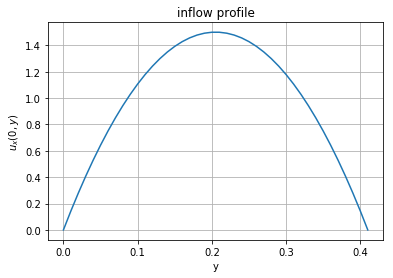

In [6]:
u = GridFunction(X)

# parabolic inflow at bc=1:
uin = 1.5*4*y*(0.41-y)/(0.41*0.41)
u.components[0].Set(uin, definedon=mesh.Boundaries("inlet"))

# a sketch of the inflow profile:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

s = np.arange(0.0, 0.42, 0.01)
bvs = 6*s*(0.41-s)/(0.41)**2 
plt.plot(s, bvs)

plt.xlabel('y')
plt.ylabel('$u_x(0,y)$')
plt.title('inflow profile')
plt.grid(True)
plt.show()

To solve the Stokes (and later the Navier-Stokes) problem, we introduce the bilinear form:
$$a((u,p),(b,q)) := \int_\Omega \nu \nabla u \cdot \nabla v - div(v)p - div(u)q$$

In [9]:
# code from website seems buggy. Redraw() before Draw(), solution vector with infs and nans
ux,uy,p = X.TrialFunction()
vx,vy,q = X.TestFunction()

div_u = grad(ux)[0]+grad(uy)[1]
div_v = grad(vx)[0]+grad(vy)[1]

stokes = nu*grad(ux)*grad(vx)+nu*grad(uy)*grad(vy) \
         -div_u*q-div_v*p
        
a = BilinearForm(X)
a += SymbolicBFI(stokes)
a.Assemble()

f = LinearForm(X)   
f.Assemble()

inv_stokes = a.mat.Inverse(X.FreeDofs())

res = f.vec.CreateVector()
res.data = f.vec - a.mat*u.vec
u.vec.data += inv_stokes * res

Redraw()

In [5]:
# this modified code requires umfpack
ux,uy,p = X.TrialFunction()
vx,vy,q = X.TestFunction()

div_u = grad(ux)[0]+grad(uy)[1]
div_v = grad(vx)[0]+grad(vy)[1]

# without the small p*q term, the matrix is not invertible.
stokes = nu*grad(ux)*grad(vx)+nu*grad(uy)*grad(vy)-div_u*q-div_v*p - 1.0e-10*p*q
        
a = BilinearForm(X)
a += SymbolicBFI(stokes)
a.Assemble()
# print(a.mat)   #gives reasonable values a.mat is a SparseMatrixD
f = LinearForm(X)   
# note: no rhs to integrate (I think this means assume rhs is zero)
f.Assemble()

# dd: edited to add the type of inverse
inv_stokes = a.mat.Inverse(X.FreeDofs(), inverse="umfpack")  # a BaseMatrix - kernel crash if I try to print

res = f.vec.CreateVector()
res.data = f.vec - a.mat*u.vec
# note f.vec is all zeros, so don't need to explicitly add...

# this doesn't make sense to me.  
# since f.vec is all zeros, it seems that we are just going doing u = u-a*a^-1*u or u = u-u = 0
u.vec.data += inv_stokes * res
# print(u.vec) gives lots of -nan -- why?  Something wrong with inv_stokes perhaps?


RuntimeError: SparseMatrix::InverseMatrix:  UmfpackInverse not available

For the time integration we consider an semi-implicit Euler method (IMEX) where the convection is treated only explicitly and the remaining part implicitly:

Find $(u^{n+1}, p^{n+1}) \in X = V \times V \times Q$, s.t. for all $(v,q) \in X$<br>
$$m(u^{n+1},v) + \Delta t \cdot a((u^{n+1},p^{n+1}),(v,q)) = m(u^n,v) - \Delta tc(u^n; u^n, v)$$

where we define $M^*$ to be the l.h.s with 

$$m(u,v) = \int u \cdot v$$

and 

$$ c(w,u,v) = \int w \cdot \nabla u \cdot v$$

We prefer the incremental form (as it homogenizes the boundary conditions):
$$m(\Delta u^{n+1}, v) + \Delta t \cdot a((\Delta u^{n+1}, p^{n+1}),(v,q)) = \Delta t(-a((u^n,p^n),(v,q)) - c(u^n; u^n, v))$$

I don't understand this notation with the semicolon.  Is c the convection part?  I think so.  Where is this in the original equation?



In [10]:
dt = 0.001
# matrix for implicit Euler 
mstar = BilinearForm(X)
# again we are adding the velocity components -- how does it make sense?
mstar += SymbolicBFI(ux*vx+uy*vy + dt*stokes)
mstar.Assemble()
inv = mstar.mat.Inverse(X.FreeDofs())

velocity = CoefficientFunction (u.components[0:2])

conv = LinearForm(X)
conv += SymbolicLFI(velocity*grad(u.components[0])*vx)
conv += SymbolicLFI(velocity*grad(u.components[1])*vy)

# for visualization
velocity = CoefficientFunction (u.components[0:2])
Draw(u.components[2],mesh,"p")
Draw(Norm(velocity),mesh,"velocity", sd=3)


In [11]:
t = 0
tend = 0

In [12]:
# implicit Euler/explicit Euler splitting method:
tend += 1
while t < tend-0.5*dt:
    print ("\rt=", t, end="")

    conv.Assemble()
    res.data = a.mat * u.vec + conv.vec
    u.vec.data -= dt * inv * res    

    t = t + dt
    Redraw()


t= 0.999000000000000876

## Supplementary 1: Computing stresses

In the previously used benchmark the stresses on the obstacle are evaluated, the so-called drag and lift coefficients.

The force acting on the obstacle is
$$F_\circ =(FD,FL)= \int_{\Gamma_{cyl}} \sigma n = \int_{\Gamma_{cyl}} (\nu \frac{\partial u}{\partial n} + pI) \cdot n$$ 

The drag/lift coefficients are
$$c_D=\frac{2}{\bar{u}L} F_D, \hspace{2em} c_L=\frac{2}{\bar{u}L} F_L.$$
where $\bar{u}=1$ is the mean inflow velocity and $L=0.41$ is the channel width.

We use the residual of our discretization to compute the forces. On the boundary degrees of freedoms of the disk we overwrote the equation by prescribing the (homogeneous) boundary conditions. The equations related to these dofs describe the force (im)balance at this boundary.

Testing the residual (functional) with the characteristic function on that boundary (in the x- or y-direction) we obtain the integrated stresses (in the x- or y-direction):

We define the functions which are characteristic functions (in terms of boundary evaluations)

In [13]:
drag_x_test = GridFunction(X)
drag_x_test.components[0].Set(CoefficientFunction(-20.0), definedon=mesh.Boundaries("cyl"))
drag_y_test = GridFunction(X)
drag_y_test.components[1].Set(CoefficientFunction(-20.0), definedon=mesh.Boundaries("cyl"))

We will collect drag and lift forces over time and therefore create empty arrays

and reset initial data (and time)


In [14]:
time_vals = []
drag_x_vals = []
drag_y_vals = []

In [15]:
# restoring initial data
res.data = f.vec - a.mat*u.vec
u.vec.data += inv_stokes * res
Redraw()

t = 0
tend = 0



With the same discretization as before.

Remarks:

- you can call the following block several times to continue a simulation and collect more data
- note that you can reset the array without rerunning the simulation
- below you can plot the gathered drag and lift values



In [16]:
# implicit Euler/explicit Euler splitting method:
tend += 1
while t < tend-0.5*dt:
    print ("\rt=", t, end="")

    conv.Assemble()
    res.data = a.mat * u.vec + conv.vec
    u.vec.data -= dt * inv * res    

    t = t + dt
    Redraw()
   
    time_vals.append( t )
    drag_x_vals.append(InnerProduct(res, drag_x_test.vec) )
    drag_y_vals.append(InnerProduct(res, drag_y_test.vec) )
    #print(drag)  

t= 0.999000000000000876

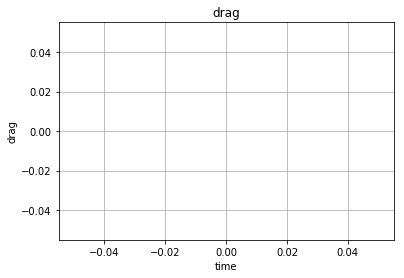

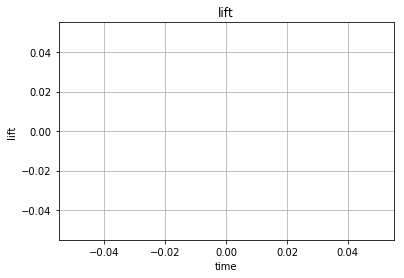

In [17]:
# Plot drag/lift forces over time

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

plt.plot(time_vals, drag_x_vals)
plt.xlabel('time')
plt.ylabel('drag')
plt.title('drag')
plt.grid(True)
plt.show()    

plt.plot(time_vals, drag_y_vals)
plt.xlabel('time')
plt.ylabel('lift')
plt.title('lift')
plt.grid(True)
plt.show()    